# Australian dataset: monthly analysis

In [1]:
%run preamble.py
ausautoBI8999 = pd.read_csv("../Data/ausautoBI8999.csv")
pm.__version__

'3.9.3'

In [2]:
from datetime import datetime
aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
                 pd.DataFrame({'year':np.array([datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
                                                for k in range(len(ausautoBI8999["FinDate"]))])})
                ], axis = 1)

# Rolling quantiles

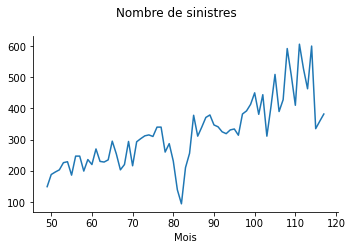

In [3]:
count_nb_claim = aus.groupby('FinMth').count()['AggClaim'].reset_index()
fig, axs = plt.subplots(1,1, figsize=(5, 3.5), tight_layout = True)


axs.plot(count_nb_claim['FinMth'], count_nb_claim['AggClaim'])
axs.set_xlabel('Mois')


sns.despine()
plt.suptitle("Nombre de sinistres")
plt.savefig("../Figures/monthly_n_claim_aus.pdf")


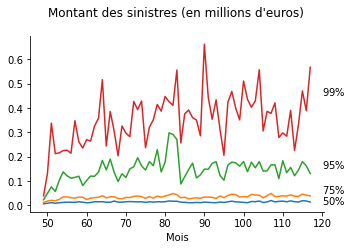

In [4]:
#Rolling mean, median 95 and 99% quantile for years and month
Quantities = ['q50', 'q75', 'q95', 'q99']
Quantity_labels  = ["Quantile à $50\%$",
                   "Quantile à $75\%$",
                   "Quantile à $95\%$",
                   "Quantile à $99\%$"
                  ]
aus['scaled_aggclaims'] = aus['AggClaim'] / 1e6 
monthly_df = pd.DataFrame({'month':np.unique(aus['FinMth']),
                          'q50':aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.5).values.flatten(), 
                          'q75': aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.75).values.flatten(), 
                          'q95': aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.95).values.flatten(), 
                          'q99' : aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.99).values.flatten()}
                        )

fig, axs = plt.subplots(1,1, figsize=(5, 3.5), tight_layout = True)

for k, quantity in enumerate(Quantities):
    axs.plot(monthly_df['month'], monthly_df[quantity], label = Quantity_labels[k])
axs.set_xlabel('Mois')


axs.text(120, 0.005,'$50\%$', fontsize = 10)
axs.text(120, 0.05,'$75\%$', fontsize = 10)
axs.text(120, 0.15,'$95\%$', fontsize = 10)
axs.text(120, 0.45,'$99\%$', fontsize = 10)
sns.despine()
plt.suptitle("Montant des sinistres (en millions d'euros)")
plt.savefig("../Figures/monthly_rolling_quantile_aus.pdf")


In [ ]:
# Prior settings
months = np.unique(aus['FinMth'])
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
traces_monthly, summaries_monthly = [], []
for month in months:
    print("Fitting month "+str(month))
    selec = aus['FinMth'].values == month
    X = aus['scaled_aggclaims'].iloc[selec].values
    model_prior, a, b =  "gamma", 0.1 * np.ones(3), 0.1 * np.ones(3)
    # SMC settings
    popSize, verbose, smc_method, paralell, nproc = 1000, False, "likelihood_anealing", True, 40
    start_time = time()
    traces_month, summary_month = fit_composite_models_smc(X, loss_models, model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
    print("Time: "+str(time() -  start_time))
    summary_month['month'] = month
    traces_monthly.append(traces_month)
    summaries_monthly.append(summary_month)

Fitting month 49
Time: 100.11994886398315
Fitting month 50
Time: 99.59983825683594
Fitting month 51
Time: 104.42340183258057
Fitting month 52
Time: 98.73501086235046
Fitting month 53
Time: 99.84885001182556
Fitting month 54
Time: 99.27994632720947
Fitting month 55
Time: 101.61015677452087
Fitting month 56
Time: 101.31344795227051
Fitting month 57
Time: 103.11061072349548
Fitting month 58
Time: 98.70257806777954
Fitting month 59
Time: 103.08612275123596
Fitting month 60
Time: 100.44750356674194
Fitting month 61


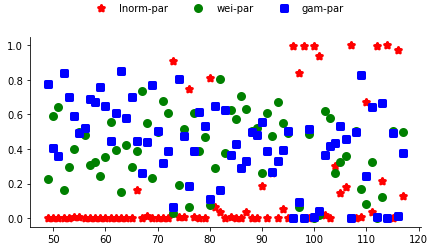

In [11]:
summaries_df = pd.concat(summaries_monthly)
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
linestyles = ['solid', 'dashed', 'dotted']
colors = ['red', "green", "blue"]
markers = ["*", "o", "s"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df['loss_model'].values == loss_model
#     plt.plot(summaries_df['month'].iloc[selec].values, summaries_df['model_evidence'].iloc[selec].values,
#              label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df['month'].iloc[selec].values, summaries_df['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3, marker = markers[k])

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_model_evidence_aus_data_1.pdf")

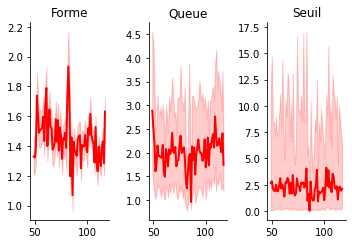

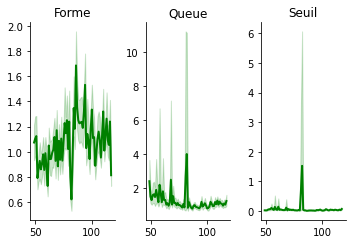

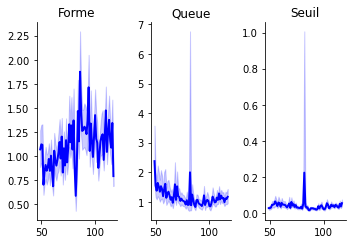

In [12]:
parms_names = ["shape", "tail", "thres"]
title_labs = ["Forme", "Queue", "Seuil"]
for j, loss_model in enumerate(loss_models):
    df_list = []
    for k, month in enumerate(months):
        df = traces_monthly[k][loss_model]
        df['month'] = np.repeat(month, popSize)
        df_list.append(df)
    df_trace = pd.concat(df_list)
    q5 = df_trace.groupby('month').quantile(0.05)
    MAP =df_trace.groupby('month').mean()
    q95 = df_trace.groupby('month').quantile(0.95)
    fig, axs = plt.subplots(1,3, figsize=(5, 3.5), tight_layout = True)
    for k, parm_name in enumerate(parms_names):
        axs[k].plot(months, MAP[parm_name], color = colors[j], linewidth=2)
        axs[k].fill_between(months, q5[parm_name].values, q95[parm_name].values, alpha=0.2, color = colors[j])
        axs[k].set_title(title_labs[k])
    sns.despine()
    plt.savefig("../Figures/monthly_post_map_"+str(loss_model)+"_aus_data.pdf")

In [13]:
loss_model = "gam-par"
for k, month in enumerate(months):
    df = traces_monthly[k][loss_model]
    df['month'] = np.repeat(month, popSize)
    df_list.append(df)
df_trace = pd.concat(df_list)
q5 = df_trace.groupby('month').quantile(0.05)
MAP =df_trace.groupby('month').mean()
q95 = df_trace.groupby('month').quantile(0.95)
MAP =df_trace.groupby('month').mean()
MAP
MAP.thres.max()
MAP.iloc[np.where(MAP.thres == MAP.thres.max())] 

,shape,tail,thres
month,,,
82,0.588748,1.995311,0.224008


In [14]:
summaries_df['index'] = np.arange(0, len(months) * 3, 1)
VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, summaries_df['loss_model'].iloc[k], summaries_df[parms_names].iloc[k].values), 
     quantile_compo(0.99, summaries_df['loss_model'].iloc[k], summaries_df[parms_names].iloc[k].values )] 
                              for k in range(len(summaries_df))]), 
                        index = np.arange(0, len(months) * 3, 1))
VaRs.columns = ['q95_compo', 'q99_compo']

quantile_df = pd.merge(summaries_df, VaRs.reset_index()).set_index('index')

quantile_df['q95_weighted'] = quantile_df['q95_compo'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99_compo'] * quantile_df['model_evidence']

q_ens = quantile_df[['month', 'q95_weighted', 'q99_weighted']].groupby('month').sum().reset_index().rename(columns = {"q95_weighted":"q95",
                                                                                                                    "q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(monthly_df[['month', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))
q_compo = quantile_df[['month',"loss_model", "q95_compo","q99_compo"] ].rename(columns = {"q95_compo":"q95","q99_compo":"q99"})
q_df = pd.concat([q_compo, q_ens, q_emp])
q_df


,month,loss_model,q95,q99
0,49,lnorm-par,0.145180,0.359311
1,49,wei-par,0.027543,0.053509
2,49,gam-par,0.027953,0.055064
3,50,lnorm-par,0.304423,0.750359
4,50,wei-par,0.053219,0.153833
...,...,...,...,...
64,113,empirical,0.121866,0.225592
65,114,empirical,0.145405,0.332090
66,115,empirical,0.179807,0.470364
67,116,empirical,0.162538,0.388811


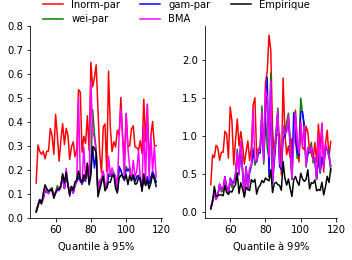

In [15]:
loss_models, colors, model_labs = ["lnorm-par", "wei-par", "gam-par", "ensemble", "empirical"] ,\
["red", "green", "blue","magenta", "black"] , ["lnorm-par", "wei-par", "gam-par","BMA", "Empirique"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df['loss_model'].values == loss_model
    axs[0].plot(q_df['month'].iloc[selec], q_df['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("Quantile à $95\%$")
    axs[1].plot(q_df['month'].iloc[selec], q_df['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("Quantile à $99\%$")

axs[0].set_ylim([0, 0.8])
# axs[1].set_ylim([0, 2.8])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.45, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_q_compo_aus_data_1.pdf")

# SMC inference of the Weibull-Pareto and gamma-Pareto composite models without lognormal-Pareto

In [16]:
selec = np.array(summaries_df.loss_model == "wei-par") | np.array(summaries_df.loss_model == "gam-par")
df = summaries_df.iloc[selec]
log_marg_df = df[['month', 'log_marg']].groupby('month').max('log_marg').rename(columns = {'log_marg':'max_log_marg'})
df = pd.merge(df, log_marg_df.reset_index(), on = 'month')
df['marg'] =  np.exp(df.log_marg - df.max_log_marg)
marg_df = df[['month', 'marg']].groupby('month').sum('marg').reset_index().rename(columns = {'marg' : "sum_marg"})
df = pd.merge(df, marg_df, on = 'month')
df['model_evidence'] = df.marg / df.sum_marg
summaries_df_2 = df[['month', 'loss_model','log_marg', 'DIC', "WAIC", "model_evidence"] + parms_names ]
summaries_df_2

,month,loss_model,log_marg,DIC,WAIC,model_evidence,shape,tail,thres
0,49,wei-par,536.200100,-1104.041469,-1089.355446,0.224826,1.073217,2.423532,0.026569
1,49,gam-par,537.437858,-1103.136306,-1089.588019,0.775174,1.070625,2.373949,0.027579
2,50,wei-par,588.922947,-1208.642360,-1195.529461,0.592241,1.104261,1.516248,0.025693
3,50,gam-par,588.549711,-1207.960117,-1195.486692,0.407759,1.122732,1.550886,0.027717
4,51,wei-par,563.500376,-1158.280252,-1145.456709,0.642208,1.124307,1.317428,0.027341
...,...,...,...,...,...,...,...,...,...
133,115,gam-par,714.704486,-1460.942166,-1448.129983,0.495689,1.088536,1.113904,0.051344
134,116,wei-par,815.744497,-1662.596771,-1650.901215,0.527748,1.239957,1.054777,0.033534
135,116,gam-par,815.633392,-1664.391227,-1652.008380,0.472252,1.344417,1.092069,0.037075
136,117,wei-par,920.883498,-1874.468797,-1861.866951,0.567226,0.813202,1.264987,0.073117


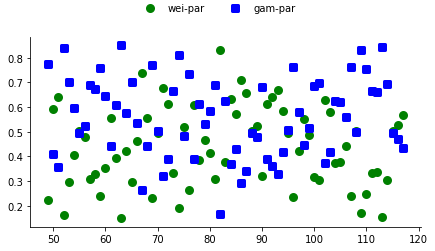

In [17]:
linestyles = ['dashed', 'dotted']
colors = ["green", "blue"]
markers = ["o", "s"]
loss_models = ['wei-par', "gam-par"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df_2['loss_model'].values == loss_model
#     plt.plot(summaries_df_2['month'].iloc[selec].values, summaries_df_2['model_evidence'].iloc[selec].values,
#              label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df_2['month'].iloc[selec].values, summaries_df_2['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3, marker = markers[k])

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], ncol = 2, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_model_evidence_aus_data_2.pdf")

In [18]:
parms_names = ["shape", "tail", "thres"]

VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, summaries_df_2['loss_model'].iloc[k], 
                                              summaries_df_2[parms_names].iloc[k].values), 
     quantile_compo(0.99, summaries_df_2['loss_model'].iloc[k], summaries_df_2[parms_names].iloc[k].values )] 
                              for k in range(len(summaries_df_2))]), 
                        index = np.arange(0, len(months) * 2, 1))
VaRs.columns = ['q95_compo', 'q99_compo']

quantile_df = pd.merge(summaries_df_2.reset_index(), VaRs.reset_index()).set_index('index')

quantile_df['q95_weighted'] = quantile_df['q95_compo'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99_compo'] * quantile_df['model_evidence']

q_ens = quantile_df[['month', 'q95_weighted', 'q99_weighted']].groupby('month').sum().reset_index().rename(columns = {"q95_weighted":"q95",
                                                                                                                    "q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(monthly_df[['month', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))
q_compo = quantile_df[['month',"loss_model", "q95_compo","q99_compo"] ].rename(columns = {"q95_compo":"q95","q99_compo":"q99"})
q_df_2 = pd.concat([q_compo, q_ens, q_emp])


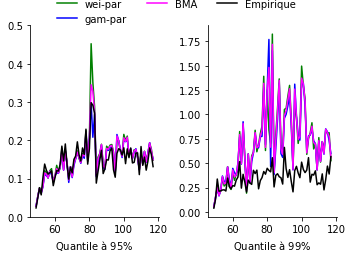

In [21]:
loss_models, colors, model_labs = [ "wei-par", "gam-par", "ensemble", "empirical"] ,\
["green", "blue","magenta", "black"] , [ "wei-par", "gam-par","BMA", "Empirique"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_2['loss_model'].values == loss_model
    axs[0].plot(q_df_2['month'].iloc[selec], q_df_2['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("Quantile à $95\%$")
    axs[1].plot(q_df_2['month'].iloc[selec], q_df_2['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("Quantile à $99\%$")

axs[0].set_ylim([0, 0.5])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.43, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_q_compo_aus_data_2.pdf")

# SMC inference of lognormal model to be compared with the weibull and gamma models

In [22]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

In [23]:
traces_lnorm = []
for month in months:
    print("Fitting month "+str(month))
    selec = aus['FinMth'].values == month
    X = aus['scaled_aggclaims'].iloc[selec].values
    with pm.Model() as model_sev:
        μ = pm.Normal("mu",mu=0, sigma=10)
        σ = pm.Gamma("sig",alpha = 0.1, beta = 0.1)
        U = pm.Lognormal("U", mu=μ, sigma=σ, observed=X)
        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1)
        traces_lnorm.append(trace)

Fitting month 49
CPU times: user 21.5 s, sys: 1.15 s, total: 22.7 s
Wall time: 4.34 s
Fitting month 50
CPU times: user 22.5 s, sys: 1.19 s, total: 23.6 s
Wall time: 3.19 s
Fitting month 51
CPU times: user 22.3 s, sys: 1.36 s, total: 23.7 s
Wall time: 3.2 s
Fitting month 52
CPU times: user 22.5 s, sys: 1.22 s, total: 23.7 s
Wall time: 3.23 s
Fitting month 53
CPU times: user 22.7 s, sys: 1.1 s, total: 23.8 s
Wall time: 3.3 s
Fitting month 54
CPU times: user 22.5 s, sys: 1.25 s, total: 23.7 s
Wall time: 3.24 s
Fitting month 55
CPU times: user 22.5 s, sys: 1.12 s, total: 23.7 s
Wall time: 3.21 s
Fitting month 56
CPU times: user 22.5 s, sys: 1.32 s, total: 23.8 s
Wall time: 3.36 s
Fitting month 57
CPU times: user 22.5 s, sys: 1.21 s, total: 23.7 s
Wall time: 3.22 s
Fitting month 58
CPU times: user 22.5 s, sys: 1.23 s, total: 23.7 s
Wall time: 3.26 s
Fitting month 59
CPU times: user 22.7 s, sys: 1.17 s, total: 23.9 s
Wall time: 3.44 s
Fitting month 60
CPU times: user 22.5 s, sys: 1.23 s, tot

In [24]:
res = pd.concat([
    summaries_df_2.reset_index()[['loss_model', 'month', 'log_marg']],
    pd.DataFrame({
        'loss_model': np.repeat("lnorm", len(months)),
        'month': months,
        'log_marg':np.array([traces_lnorm[k].report.log_marginal_likelihood for k in range(len(traces_lnorm))]).flatten()
        })
])
res_1 = pd.merge(res, res.groupby('month').max('log_marg').reset_index().rename(columns = {"log_marg":"max_log_marg"}))
res_1['marg'] = np.exp(res_1['log_marg']- res_1['max_log_marg'])
res_2  = pd.merge(res_1, res_1.groupby('month').sum('marg')['marg'].reset_index().rename(columns = {"marg":"sum_marg"}))
res_2['model_evidence'] = res_2['marg'] / res_2['sum_marg']
summaries_df_3 = res_2[['loss_model', 'month', 'log_marg', "model_evidence"]]
summaries_df_3

,loss_model,month,log_marg,model_evidence
0,wei-par,49,536.200100,2.248263e-01
1,gam-par,49,537.437858,7.751731e-01
2,lnorm,49,523.290924,5.564976e-07
3,wei-par,50,588.922947,5.921915e-01
4,gam-par,50,588.549711,4.077252e-01
...,...,...,...,...
202,gam-par,116,815.633392,2.197193e-03
203,lnorm,116,821.749303,9.953474e-01
204,wei-par,117,920.883498,2.588171e-01
205,gam-par,117,920.612955,1.974684e-01


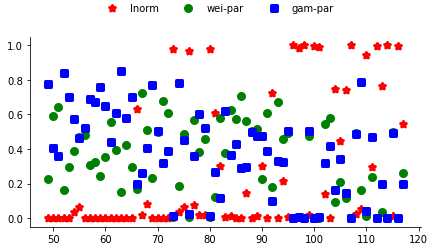

In [25]:
loss_models = ["lnorm", "wei-par", "gam-par"]
linestyles = ['solid', 'dashed', 'dotted']
colors = ['red', "green", "blue"]
markers = ["*", "o", "s"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df_3['loss_model'].values == loss_model
#     plt.plot(summaries_df_3['month'].iloc[selec].values, summaries_df_3['model_evidence'].iloc[selec].values,
#              label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df_3['month'].iloc[selec].values, summaries_df_3['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3, marker = markers[k])
#     plt.xticks(summaries_df_3['month'].iloc[selec].values)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_model_evidence_aus_data_3.pdf")

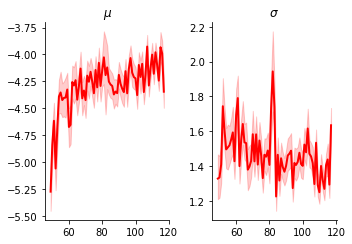

In [26]:
list_df = []
for i in range(len(traces_lnorm)):
    res = pd.DataFrame({
        "mu":traces_lnorm[i]["mu"],
        "sig": traces_lnorm[i]["sig"]})
    res["month"] = months[i]
    list_df.append(res)
traces_lnorm_df = pd.concat(list_df)

parms_names = ["mu", "sig"]
title_labs = ["$\mu$", "$\sigma$"]

q5 = traces_lnorm_df.groupby('month').quantile(0.05)
MAP =traces_lnorm_df.groupby('month').mean()
q95 = traces_lnorm_df.groupby('month').quantile(0.95)
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, parm_name in enumerate(parms_names):
    axs[k].plot(months, MAP[parm_name], color = 'red', linewidth=2)
    axs[k].fill_between(months, q5[parm_name].values, q95[parm_name].values, alpha=0.2, color = "red")
    axs[k].set_title(title_labs[k])
sns.despine()
plt.savefig("../Figures/monthly_post_map_lnorm_aus_data.pdf")

In [27]:
list_q = []
map_lnorm = traces_lnorm_df.groupby('month').mean().reset_index()
for k in range(len(months)):
    mu, sig = map_lnorm[["mu", "sig"]].iloc[k]
    res = st.lognorm(s = sig , scale = np.exp(mu)).ppf([0.95, 0.99])
    list_q.append(res)
q_lnorm = pd.DataFrame(np.vstack(list_q), columns = ["q95", "q99"])
q_lnorm["month"] = months
q_lnorm["loss_model"] = np.repeat("lnorm", len(months))
q_lnorm
selec = np.array(q_df_2['loss_model'] == "wei-par") | np.array(q_df_2['loss_model'] == "gam-par") 
q_compo = q_df_2.iloc[selec]
quantile_df = pd.merge(summaries_df_3[["loss_model", "month", "model_evidence"]], pd.concat([q_lnorm, q_compo]), 
         on = ["loss_model", "month"] )
quantile_df['q95_weighted'] = quantile_df['q95'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99'] * quantile_df['model_evidence']
q_ens = quantile_df[['month', 'q95_weighted', 'q99_weighted']].groupby('month').sum().reset_index().\
rename(columns = {"q95_weighted":"q95","q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(monthly_df[['month', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))

q_df_3 = pd.concat([q_compo, q_lnorm, q_ens, q_emp])

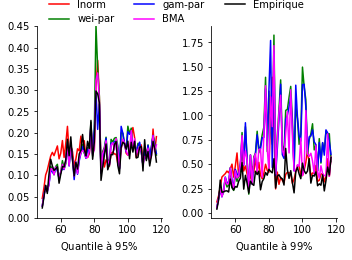

In [29]:
# loss_models, colors, model_labs = ["lnorm",  "empirical"] ,\
# ["red", "black"] , ["lnorm", "Empirique"]
loss_models, colors, model_labs = ["lnorm", "wei-par", "gam-par", "ensemble", "empirical"] ,\
["red", "green", "blue","magenta", "black"] , ["lnorm", "wei-par", "gam-par","BMA", "Empirique"]

fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_3['loss_model'].values == loss_model
    axs[0].plot(q_df_3['month'].iloc[selec], q_df_3['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("Quantile à $95\%$")
    axs[1].plot(q_df_3['month'].iloc[selec], q_df_3['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("Quantile à $99\%$")

axs[0].set_ylim([0, 0.5])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.45, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_q_compo_aus_data_3.pdf")